# River bifurcation in CONUS workflow
This notebook contains the workflow necessary to extract data from a HUC4 and join it to NABD for bifurcation analysis.

## 1. Install packages

In [ ]:
# import sys
# !{sys.executable} -m pip install geofeather
# !{sys.executable} -m pip install nhdnet  #see Setup info document 

## 2. Load modules

In [2]:
# Basic analysis 
from pathlib import Path
import os
from time import time
import geopandas as gp
import geofeather
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt

# Set path
gdrive = Path("/Volumes/GoogleDrive/My Drive/Condon_Research_Group/Research_Projects/Rachel/Research/GIS/Layers") # where shapefiles live on the Drive

## 3. Read in the sample geodatabase

### 3.1 Read in the HUC4 shapefile (1019) I made 

In [3]:
## larger dataset
# flowlines_test = gp.read_file(gdrive/"HUC_test/Test1029.shp")       # this is actually HUC 1019

## subset of above data
flowlines_test = pd.read_csv(gdrive/"NHDPlusNationalData/small1019.csv")

flowlines_test = flowlines_test.rename(columns={"REACHCODE": "Reachcode"})  # rename columns  
flowlines_test = flowlines_test.rename(columns={"StreamOrde": "streamorder"})
flowlines_test = flowlines_test.rename(columns={"LENGTHKM": "length"})
# print(flowlines_test)
# list(flowlines_test.columns)

### 3.2 Checks and cleanup of 'flowlines_test'

In [4]:
# Checking flowlines
flowlines_test.head(3)            # see the first 3 rows
# type(flowlines_test.streamorder)  # check data type
# print(len(flowlines_test))        # check length
# set(flowlines_test.streamorder)   # list unique streamorder values

# Cleanup columns
# imp_cols2 = ['OBJECTID', 'COMID', 'Reachcode', 'streamorder', 'geometry', 'Hydroseq', 'UpHydroseq', 'DnHydroseq', 'length']  # specify columns we want to keep
imp_cols2 = ['OBJECTID', 'COMID', 'Reachcode', 'streamorder', 'WKT', 'Hydroseq', 'UpHydroseq', 'DnHydroseq', 'length'] # for subset
flowlines_test = flowlines_test[imp_cols2]  # filter dataframe with specified columns
# print(flowlines_test)

# Plotting
# flowlines_test[flowlines_test.streamorder>0].plot()  # Plot all stream lines

## 4. Join the two datasets (NHD and NABD)
Check [this link](https://www.earthdatascience.org/courses/use-data-open-source-python/intro-vector-data-python/vector-data-processing/spatial-joins-in-python-geopandas-shapely/) out for help: 

See also: https://geopandas.org/mergingdata.html

https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

### 4.1 Read NABD and plot

In [5]:
# Read in NABD shapefile
nabd = gp.read_file(gdrive/"nabd_fish_barriers_2012.shp")  # read in NABD from Drive
imp_cols3 = ['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']  # specify columns we want to keep
nabd = nabd[imp_cols3]  # filter dataframe with specified columns
print(list(nabd.columns))
# print(len(nabd))

['NIDID', 'COMID', 'Dam_name', 'Purposes', 'Year_compl', 'Norm_stor', 'geometry']


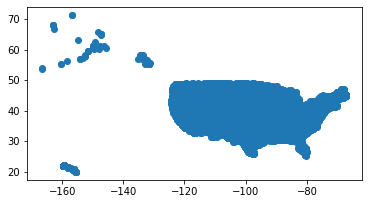

In [6]:
# Plotting check
nabd[nabd.COMID>0].plot()  # plot all dams in US

### 4.2 Merge datasets by COMID

In [7]:
# Merge NABD and NHD
nabd_nhd_join = nabd.merge(flowlines_test, how= 'right', on='COMID')  # how = 'right': merge is done by adding NABD attributes to NHD flowlines based on COMID
                                                                 # the result will have the same length as "flowlines_test"

### 4.3 Checks of 'nabd_nhd_join'

In [8]:
# Checking stuff after merge
# nabd_nhd_join.head(10)  
# nabd_nhd_join.columns
# set(nabd_nhd_join.NIDID)
# type(nabd_nhd_join)
print(len(nabd_nhd_join))  #check the merge
# print(type(nabd_nhd_join))
# print(nabd_nhd_join[nabd_nhd_join.NIDID!='NaN'])

# Plotting  *currently not working, but does not matter*

# nabd_nhd_join[nabd_nhd_join.COMID>0].plot()
# nabd_nhd_join[nabd_nhd_join.streamorder>0].plot(subplots=FALSE)



51


### 4.4 Plotting 'nabd_nhd_join'
Red =  dam on the flowline, blue = no dam

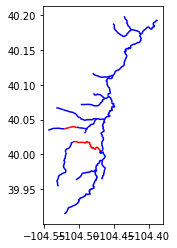

In [9]:
# Joined data
# trying to plot data when geometry is WKT
from shapely import wkt

## get WKT in the correct format
nabd_nhd_join = nabd_nhd_join.rename(columns={"WKT": "Coordinates"}) #rename column
nabd_nhd_join.Coordinates = nabd_nhd_join.Coordinates.astype(str)
# flowlines_test.COMID = flowlines_test.COMID.apply(str)
nabd_nhd_join['Coordinates'] = nabd_nhd_join['Coordinates'].apply(wkt.loads)
nabd_nhd_join_gdf = gp.GeoDataFrame(nabd_nhd_join, geometry='Coordinates')

## Checking
# print(nabd_nhd_join.head(5))
# # type(nabd_nhd_join.Coordinates)
# nabd_nhd_join.info()
# print(nabd_nhd_join_gdf.head())

## Plotting
# set(nabd_nhd_join_gdf.Norm_stor)
len(nabd_nhd_join_gdf.Norm_stor)
colors = []
for i in range(0,51):   # 
    if (pd.isnull(nabd_nhd_join_gdf['Norm_stor'][i])):
        colors.append('b')
    else:
        colors.append('r')
        

nabd_nhd_join_gdf.plot(color=colors)
# plt.savefig('Small_dataset.png', dpi = 500)
plt.show()

## 5. How to read in NHDFlowline csv
Exported the Flowline_Network feature class in the NHDPlusV21_National_Seamless_Flattened_Lower48 geodatabase to a csv. [This link](https://gis.stackexchange.com/questions/23376/how-to-export-polygons-to-csv-with-coordinates) helped me keep the geometry of the flowlines

In [10]:
# Flowline csv
# nhdflowlines = pd.read_csv(gdrive/"NHDPlusNationalData/NHDFlowlines.csv")
# nhdflowlines.head(3)

### 5.1 Checking and filtering the csv

In [11]:
# list(flowlines.columns)
# keep_cols = ['OBJECTID', 'COMID', 'REACHCODE', 'StreamOrde', 'WKT', 'Hydroseq', 'UpHydroseq', 'DnHydroseq']  # specify columns we want to keep
# nhdflowlines = nhdflowlines[keep_cols] # filter dataframe with specified columns
# nhdflowlines.head(3)
# nhdflowlines['REACHCODE']
# nhdflowlines['WKT']

### 5.2 Mess around with sample NHD

In [12]:
nhd_sample = pd.read_csv(gdrive/"NHDPlusNationalData/nhd_sample.csv")
# print(nhd_sample)

## 6. Bifurcation calculations (SARP way)
Looking at 'stats.py'

In [13]:
# nabd_nhd_join.head(3)
# # set(nabd_nhd_join.DnHydroseq)
# # x = nabd_nhd_join[nabd_nhd_join.DnHydroseq == '']
# # print(x)

# ## need to add "kind" to the df - See stats.py and Rachel_workflow
# nabd_nhd_join.loc[nabd_nhd_join.UpHydroseq > 0, 'kind'] = 'internal'   # there is stream lines above and below this flowline
# nabd_nhd_join.loc[nabd_nhd_join.UpHydroseq == 0, 'kind'] = 'origin'    # there is no stream line above this flowline
# nabd_nhd_join.loc[nabd_nhd_join.DnHydroseq == 0, 'kind'] = 'terminal'  # there is no stream line below this flowline
# # print(nabd_nhd_join.head(3))
# set(nabd_nhd_join.kind)

### 6.1 Upstream count

In [14]:
# # create series of networkID indexed by COMID?
# networkID = nabd_nhd_join
# # print(networkID)

# list(nabd_nhd_join.columns)
# # list(networkID.columns)
# # identify all barriers that are upstream of a given network by joining on their downstream Hydroseq (DnHydroseq)
# barriers_upstream = (nabd_nhd_join[["DnHydroseq", "kind"]].merge(networkID, on = 'DnHydroseq')
#                      .reset_index()[["Hydroseq"]].dropna())
# barriers_upstream.Hydroseq = barriers_upstream.Hydroseq.astype("uint32")
# # print(barriers_upstream)
# len(barriers_upstream)

# # # have to re-add column for kind
# # kind = np.zeros(26358)  # for HUC 1019
# kind = np.zeros(73)  # for subset of HUC 1019

# barriers_upstream['kind'] = kind
# # Count barriers that have a given network DOWNSTREAM of them  * do they mean upstream?
# upstream_counts = (barriers_upstream.groupby(["Hydroseq", 'kind']).size().rename("count").reset_index()
#                    .pivot(index="Hydroseq", columns='kind', values="count").rename(columns={
#                 "dam": "up_ndams"}))
# upstream_counts.head(10)
# # print(upstream_counts.columns)

### 6.2 River length

In [15]:
# network_length = nabd_nhd_join.groupby(level=0)[["length"]].sum()
# # free_length = (df.loc[~df.waterbody].groupby(level=0).length.sum().rename("free_length"))
# # temp_df = df[["length", "sinuosity"]].join(network_length, rsuffix="_total")

## 7. Bifurcation calculations (Laura pseudocode)
Goal: obtain 2 different tables that allow us to walk upstream and downstream. 

In [58]:
#Rachel workflow
# Create Segments -> [ID, Up, Down, length, FragID ] (FragID=(NIDID))
nabd_nhd_join = nabd_nhd_join.rename(columns={"Hydroseq": "ID", "UpHydroseq":"Up", "DnHydroseq":"Down", "NIDID": "fragID"}) #rename columns for easier indexing
segment_cols = ['ID', 'Up', 'Down', 'length', 'fragID']   #select the columns we want (length = km)
segments = nabd_nhd_join[segment_cols]                    #create a new df with the columns we want
# segments.head(3)

headwater_list = segments.loc[segments.Up == 0]   #select all headwaters (Upstream ID = 0)
queue_cols = ['ID']                               #only need hydrosequence ID
queue = headwater_list[queue_cols]                #create queue from filtered headwater_list
queue.ID = queue.ID.astype(str)
queue.loc[:,1] = 0                                #add new column of zeroes
queue = queue.rename(columns={1: "Frag_up"})      #rename zero column
queue = queue.reset_index(drop=True)
queue2 = pd.DataFrame()
# print(queue)                                      #check what we made 
# print('Length queue=',len(queue),                 #check length of queue and headwater_list
#       'Length headwater_list=',len(headwater_list))

for f in range(len(queue)):           #iterate over length of 'queue'
    segment_temp = queue.loc[f,'ID']  #select each ID in queue 
#     print(segment_temp)             
    segment_list = segment_temp       #assign ID to the segment list for later
#     print(segment_list)
    fragment_temp =  segments.loc[segments['ID'] == segment_temp, 'fragID']   #select the fragID where it has the same ID as segment_temp
    print(type(fragment_temp))
    length_temp = segments.loc[segments['ID'] == segment_temp, 'length']  #select the stream length where ID = segmemt_temp
#     print(length_temp)
#     frag_temp.to_frame()
#     print(type(frag_temp))
    
    if [fragment_temp == 'nan']:    #iterate through headwaters (frag_temp = 0)
#     while (pd.isnull(frag_temp['frag_temp'][i])):
        next_segment = segments.loc[segments['ID'] == segment_temp, 'Down']
#         print(next_segment)
        up_length = segments.loc[segments['ID'] == segment_temp, 'length'] 
        next_length = segments.loc[segments['ID'] == next_segment, 'length']
        segments.loc[:,6] =  up_length + next_length    #add new column for uplength? 
#         segments = segments.rename(columns={6:'upstream_length'}) 
#         segments.loc[segments['ID'] == next_segment, segments['upstream_length'] == segments.loc[segments['ID'] == next_segment, 'length'] + segments.loc[segments['ID'] == segment_temp, 'length']] #add length to downstream ID
#         seglist=c(seglist,snext)
#         ftemp=segments[snext,fragID]
#         lengthtemp=lengthtemp+segments[segnext, length]
#         segtemp=segnext

#     #Assign the fragment number to everything in the temp list
#     segments[seglist, Frag] = ftemp
#     #adding the downstream segment to the next queue
#     queue2 = c(queue2,  segments[segtemp, frag])  #queue needs to  have two columns the segment ID and the FragID that lead to i
#     #sum up the total length of the segments and add to lengthtemp
#     frag[ftemp, length]=frag[ftemp,length]+lengthtemp
#     frag[ftemp, Fup] = queue[s,2]
    
#     #clear everything out
#     seglist=null
#     lengthtemp=0
segments.head(3)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


,ID,Up,Down,length,fragID
0,550126172.0,550201446.0,550100015.0,1.604,CO00013
1,550042993.0,550044416.0,550041690.0,0.217,CO00054
2,550075102.0,550084956.0,550068063.0,5.449,CO01106


## Junk/ trying things

In [17]:
# trying to plot data when geometry is WKT
# from shapely import wkt

# ## get WKT in the correct format
# flowlines_test = flowlines_test.rename(columns={"WKT": "Coordinates"}) #rename column
# flowlines_test.Coordinates = flowlines_test.Coordinates.astype(str)
# # flowlines_test.COMID = flowlines_test.COMID.apply(str)
# flowlines_test['Coordinates'] = flowlines_test['Coordinates'].apply(wkt.loads)
# flowline_gdf = gp.GeoDataFrame(flowlines_test, geometry='Coordinates')

## Checking
# print(flowlines_test.head(5))
# # type(flowlines_test.Coordinates)
# flowlines_test.info()
# print(flowline_gdf.head())

## Plotting
# ax = flowline_gdf[flowline_gdf.streamorder>'6'].plot()
# flowline_gdf.plot(ax=ax, color='red')
# # plt.show()